In [1]:
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os
from langgraph.checkpoint.memory import MemorySaver
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import Annotated
from typing_extensions import TypedDict
import gradio as gr

d:\SmartCane\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv(override=True)

True

In [3]:
api_key=os.getenv("GOOGLE_API_KEY")
search_key=os.getenv("SEARCH_KEY")
if(api_key and search_key):
    print("Well and done")

Well and done


In [4]:
#loading Model
llm=ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    google_api_key=api_key
)

In [5]:
class State(TypedDict):
    messages:Annotated[list,add_messages]

graph_builder=StateGraph(State)

In [6]:
#agent 1
def chat(old_state:State)->State:
    system_message=f"""Your role is to talk to the user about the topic on which the blog
    needs to be generated. You must provide a blog title and ask the user
    to choose a blog length. Offer three choices:\n"
    1. short = 100 words\n
    2. medium = 200 words\n
    3. long = 400 words.
    """
    if isinstance(old_state, dict):
        messages = [system_message] + old_state.get("messages", [])
    else:
        messages = [system_message] + old_state.messages
    title=llm.invoke(messages)
    new_messages=State(messages=[title])
    return new_messages

In [7]:
def writer(old_state:State)->State:
    system_message=f"""Your role is to generate the blog body based on the provided topic title, and desired length. 
    If you need more details, call {chat} again
    """
    if isinstance(old_state, dict):
        messages = [system_message] + old_state.get("messages", [])
    else:
        messages = [system_message] + old_state.messages
    body=llm.invoke(messages)
    new_mes=State(messages=body)
    return new_mes


In [8]:
#graph builder nodes
graph_builder.add_node("chat",chat)
graph_builder.add_node("body",writer)


In [9]:
#edges
graph_builder.add_edge(START,"chat")
graph_builder.add_edge("chat","body")

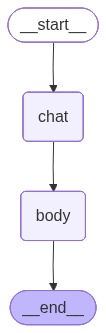

In [10]:
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
def model(user_input: str, history):
    # Make sure user_input is wrapped properly
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]})
    print(result)
    
    # Ensure safe access to the last message content
    last_msg = result
    if isinstance(last_msg, dict):
        return last_msg.get("content", "")
    return getattr(last_msg, "content", "")

import gradio as gr
gr.ChatInterface(fn=model).launch()


d:\SmartCane\.venv\Lib\site-packages\gradio\chat_interface.py:347: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  self.chatbot = Chatbot(


* Running on local URL:  http://127.0.0.1:7864
* To create a public link, set `share=True` in `launch()`.
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='blog', additional_kwargs={}, response_metadata={}, id='9902fcf2-c3bc-479a-8a8f-49938e365680'), AIMessage(content="Hello there! I'm ready to help you brainstorm and create a fantastic blog post.\n\nTo get started, could you please tell me what topic you have in mind for your blog? Once I know the subject, I can suggest a compelling title for you!", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--a51accff-623f-4f00-ac53-01db2337ccce-0', usage_metadata={'input_tokens': 85, 'output_tokens': 166, 'total_tokens': 251, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 113}}), AIMessage(content="\n\nIf you already have a title, that's great too! Just share it with me, along with your desired length for the blog post (e.g., 